# Project setup

In [1]:
dataset_zip_name = "mikroszkop-bioszenzor"
dataset_name = "20210526_LCLC_fn"
model_name = "cyto3_old_annotated"

In [ ]:
!git clone --recursive -j8 https://github.com/Nanobiosensorics/cell-aligner.git
!mv cell-aligner/* ./
!rm -rf cell-aligner

In [ ]:
!pip install -r requirements.txt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip "/content/drive/MyDrive/szakdolgozat/kepillesztes/{dataset_zip_name}.zip" -d "/content/datasets"
!mkdir models
!cp "/content/drive/MyDrive/szakmai gyakorlat/cellpose-cell-counting/models/{model_name}" "/content/models"

In [6]:
import os

file_path = "./nanobio_core/epic_cardio/data_correction.py"
backup_file_path = "./nanobio_core/epic_cardio/data_correction.bak"

if not os.path.exists(backup_file_path):
  os.rename(file_path, backup_file_path)

  with open(backup_file_path, 'r') as file:
    lines = file.readlines()

  with open(file_path, 'w') as file:
    for line in lines:
      if "matplotlib.use('Qt5Agg')" in line:
        file.write("# " + line)
      else:
        file.write(line)

# Data preprocessing

In [ ]:
from data_preprocessing import process

In [ ]:
# no magnification
process(
    input_path=f"/content/datasets/{dataset_name}",
    output_path="/content/drive/MyDrive/szakdolgozat/kepillesztes/preprocessed_1x.pkl",
    cellpose_model_path=f"models/{model_name}",
    scaling="MIC_10X",
    magnification=1,
    params={
        "preprocessing_params": {
            "flip": [False, True],
            "range_lowerbound": 0,
            "drift_correction": {
                "threshold": 75,
                "filter_method": "mean"
            }
        },
        "localization_params": {
            "threshold_range": [150, 3000],
            "neighbourhood_size": 3
        }
    }
)

In [ ]:
# magnification
process(
    input_path=f"/content/datasets/{dataset_name}",
    output_path="/content/drive/MyDrive/szakdolgozat/kepillesztes/preprocessed_2x.pkl",
    cellpose_model_path=f"models/{model_name}",
    scaling="MIC_10X",
    magnification=2,
    params={
        "preprocessing_params": {
            "flip": [False, True],
            "range_lowerbound": 0.8,
            "drift_correction": {
                "threshold": 75,
                "filter_method": "mean"
            }
        },
        "localization_params": {
            "threshold_range": [25, 5000],
            "neighbourhood_size": 3
        }
    }
)

# Stochastic aligner

---



---



In [8]:
# no magnification
!python evaluate.py eval-stochastic \
--input_path=/content/drive/MyDrive/szakdolgozat/kepillesztes/preprocessed_1x.pkl \
--output_path=/content/drive/MyDrive/szakdolgozat/kepillesztes/translations_1x.pkl \
--source_indices_ratio=1

In [9]:
# magnification
!python evaluate.py eval-stochastic \
--input_path=/content/drive/MyDrive/szakdolgozat/kepillesztes/preprocessed_2x.pkl \
--output_path=/content/drive/MyDrive/szakdolgozat/kepillesztes/translations_2x.pkl \
--source_indices_ratio=1

## Evaluating results

In [10]:
import pickle

with open("/content/drive/MyDrive/szakdolgozat/kepillesztes/preprocessed_1x.pkl", "rb") as file:
  preprocessed_1x = pickle.load(file)
with open("/content/drive/MyDrive/szakdolgozat/kepillesztes/translations_1x.pkl", "rb") as file:
  translations_1x = pickle.load(file)

with open("/content/drive/MyDrive/szakdolgozat/kepillesztes/preprocessed_2x.pkl", "rb") as file:
  preprocessed_2x = pickle.load(file)
with open("/content/drive/MyDrive/szakdolgozat/kepillesztes/translations_2x.pkl", "rb") as file:
  translations_2x = pickle.load(file)

In [14]:
def show_alignment_result(ax, well_id, preprocessed, translations):
  microscope_img = preprocessed[well_id]["microscope_data"][0]
  microscope_points = preprocessed[well_id]["microscope_data"][1]
  well_img = preprocessed[well_id]["well_data"][0]
  well_points = preprocessed[well_id]["well_data"][1]
  translation = -translations[well_id]["translation"]

  ax.set_axis_off()

  height1, width1 = microscope_img.shape[:2]
  height2, width2 = well_img.shape[:2]

  ax.imshow(microscope_img, cmap="gray")
  ax.scatter(
      microscope_points[:, 0], microscope_points[:, 1],
      color="red", alpha=0.25
  )
  ax.imshow(
      well_img, cmap="viridis", alpha=0.4,
      extent = [translation[0], translation[0]  + well_img.shape[0],
                translation[1] + well_img.shape[1], translation[1]]
  )

  ax.set_xlim([0, width1])
  ax.set_ylim([height1, 0])

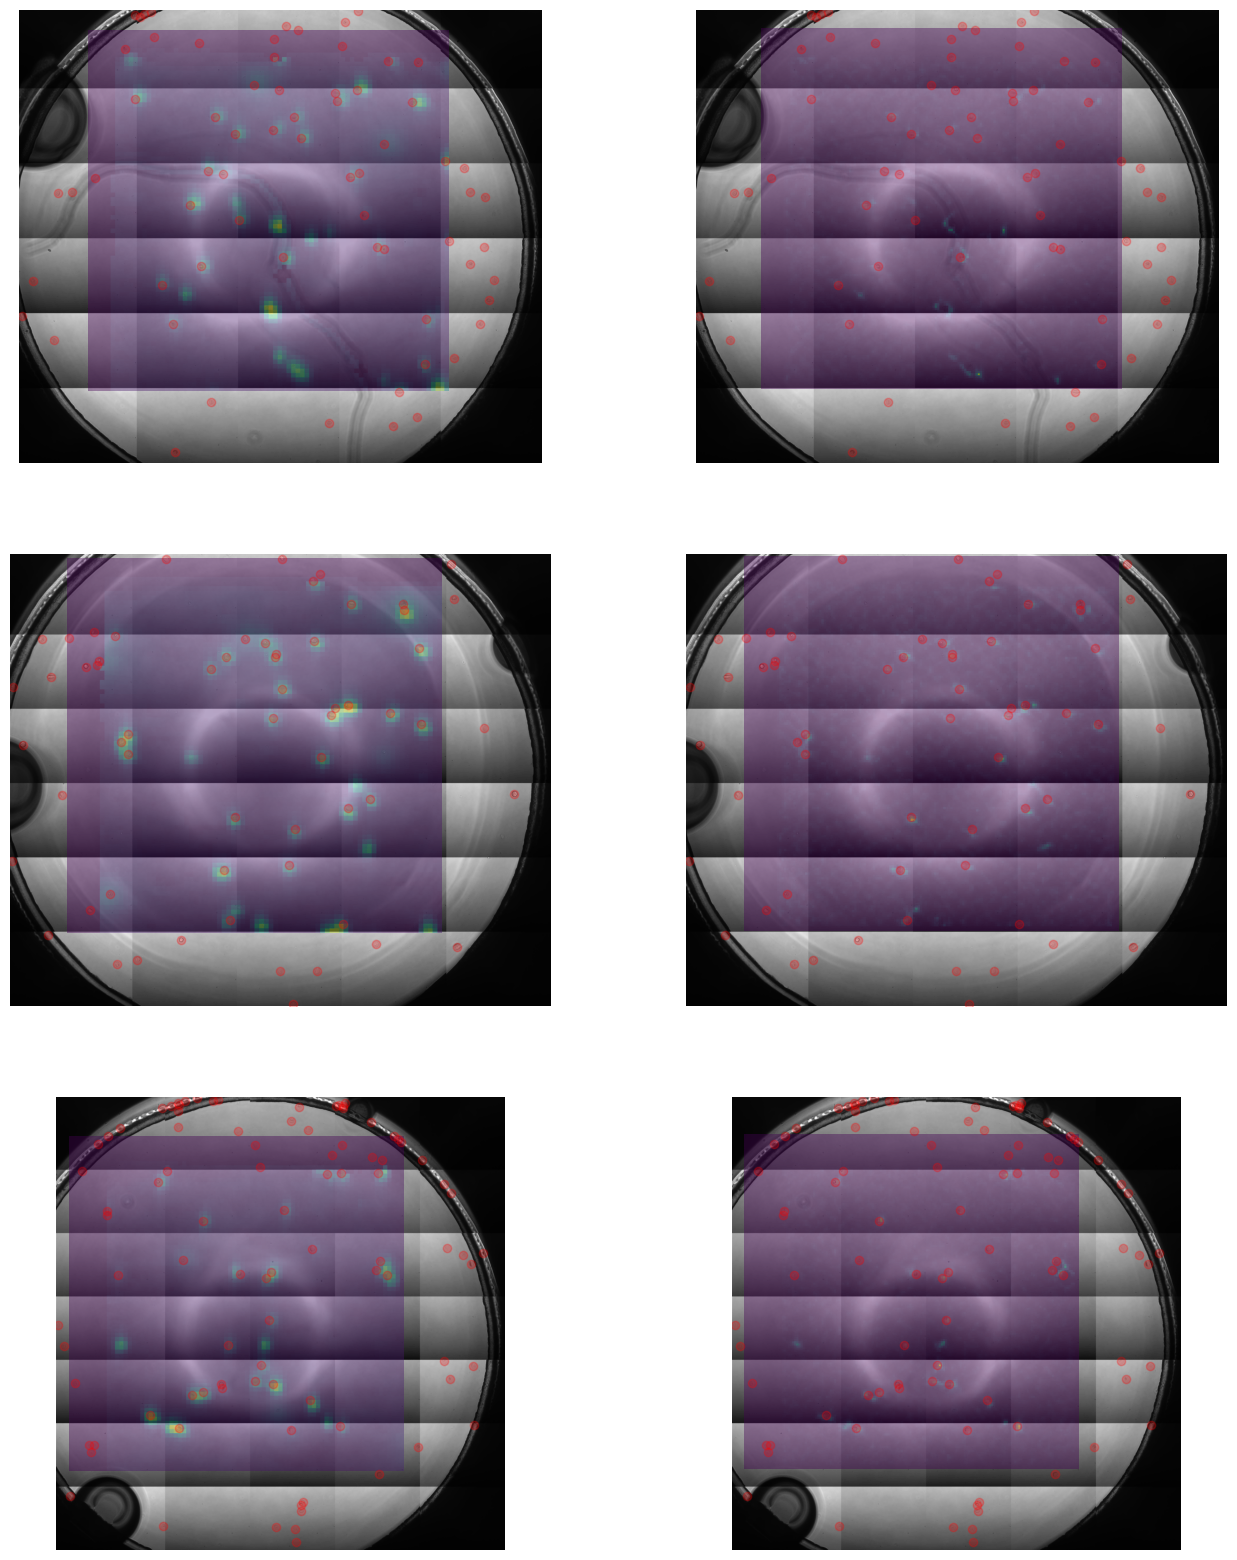

In [23]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 2, figsize=(16, 20))

show_alignment_result(axes[0][0], "A1", preprocessed_1x, translations_1x)
show_alignment_result(axes[0][1], "A1", preprocessed_2x, translations_2x)

show_alignment_result(axes[1][0], "B1", preprocessed_1x, translations_1x)
show_alignment_result(axes[1][1], "B1", preprocessed_2x, translations_2x)

show_alignment_result(axes[2][0], "C1", preprocessed_1x, translations_1x)
show_alignment_result(axes[2][1], "C1", preprocessed_2x, translations_2x)